In [50]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True



In [51]:
file = up.open('unoscillated_IBD_userfile.root')
dataset = file['TRec'].arrays(library = 'np')
print(len(dataset))

50


In [52]:
dataset['m_QEn'] = dataset['m_QEn'] * 0.92

# **Time Analysis**

Plot trigger time of consecutive events only to see they are in temporal order

In [53]:
# fig_prova, ax_prova = plt.subplots(figsize= (14,4))

(0.0, 250000000000.0)

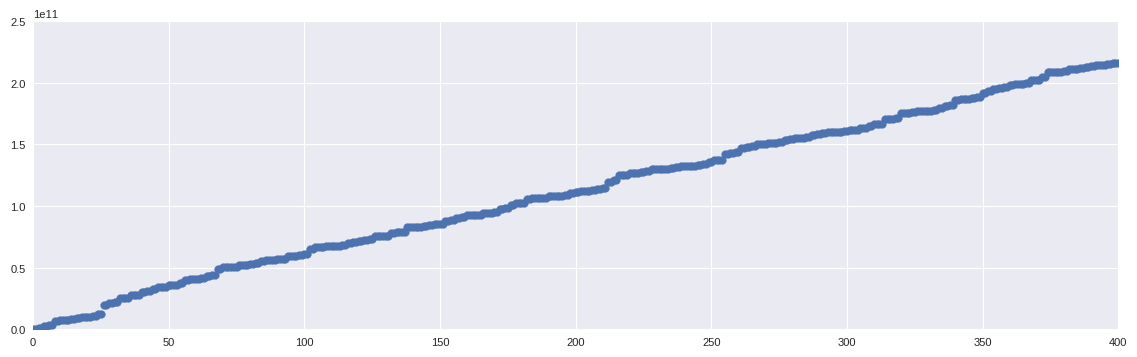

In [54]:
fig_prova, ax_prova = plt.subplots(figsize= (14,4))
ax_prova.scatter( np.arange(dataset['m_triggerT'].shape[0]) , dataset['m_triggerT'])
plt.xlim(0,  400)
plt.ylim(0,  0.25e12)

In [55]:
np.diff(dataset["m_triggerT"]).shape

(198501,)

Text(0.5, 1.0, 'Plt of delta time of consecutive events')

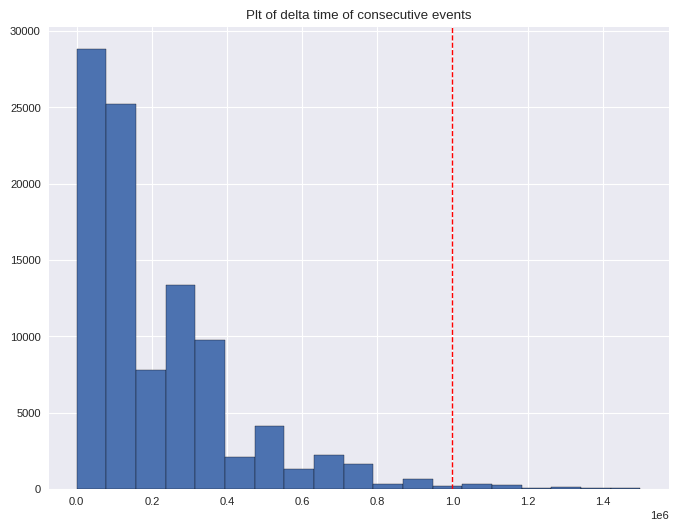

In [56]:
diff_time = np.diff(dataset["m_triggerT"]) # [( dataset["m_triggerT"][i+1] - dataset["m_triggerT"][i] ) for i in range(len(dataset)-1)]

fig_r_d, ax_r_t = plt.subplots(figsize = (8,6))
ax_r_t.hist(diff_time, np.linspace(0, 1.5e6, 20))
plt.axvline(1e6, color='red', linestyle='dashed', linewidth=1)

ax_r_t.set_title("Plt of delta time of consecutive events")



I assume that even calculating the time difference between consecutive events and plotting it I will not obtain the exponential distribution we expect from IBD because I did not tagged prompt and delayed events

# **Distance Analysis**

In [57]:
cut = 10

x1 = np.arange(cut) #dataset['recx'][:cut]
x2 = np.arange(cut) #dataset['recx'][:cut]

for v1, v2 in zip(x1[0:-1],x2[1:]):
     print(f'{v1}\t{v2}')

0	1
1	2
2	3
3	4
4	5
5	6
6	7
7	8
8	9


Text(0.5, 1.0, 'Plt of delta radius of consecutive events')

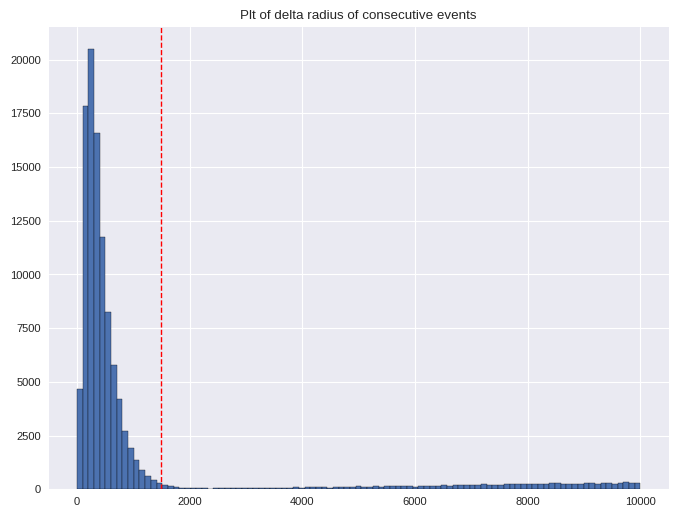

In [58]:
xs_reco = file['TRec']['recx'].array(library = 'np')
ys_reco = file['TRec']['recy'].array(library = 'np')
zs_reco = file['TRec']['recz'].array(library = 'np')
es_reco = file['TRec']['m_QEn'].array(library = 'np')

def dist(x1,x2,y1,y2,z1,z2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

fig_r_d, ax_r_d = plt.subplots(figsize = (8,6))

diff2 =  dist(dataset['recx'][1:],dataset['recx'][:-1],dataset['recy'][1:],dataset['recy'][:-1],dataset['recz'][1:],dataset['recz'][:-1])

ax_r_d.hist(diff2, np.linspace(0,10000, 100))
plt.axvline(1500, color='red', linestyle='dashed', linewidth=1)

ax_r_d.set_title("Plt of delta radius of consecutive events")

# **Divide prompt and delay signal**

Using the analysis did before we could decide the cuts that we neet to make. I perform the analysis using the cuts that in the paper have been made 

## *Energy Ranges*

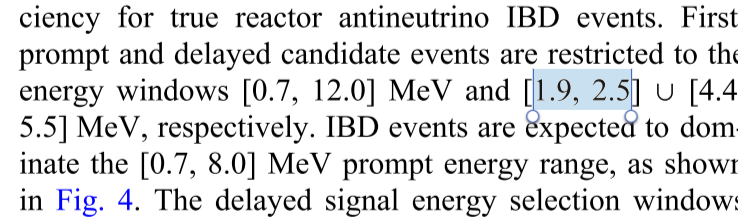

In [59]:
delta_time = 1e6  # ~200us 
delta_radius = 1500 #1.5 m
min_energy_prompt = 0.7 #MeV
max_energy_prompt = 12

min_energy_delay = 1.9 #MeV
max_energy_delay = 2.5

#Here I made some changes
min_energy_delay_carb = 4.4 #MeV
max_energy_delay_carb = 5.5



In [60]:
mask_t = dataset["m_triggerT"][:-1] - dataset["m_triggerT"][1:] < delta_time
mask_r = dist(dataset['recx'][1:],dataset['recx'][:-1],dataset['recy'][1:],dataset['recy'][:-1],dataset['recz'][1:],dataset['recz'][:-1]) < delta_radius
mask_rt = np.logical_and(mask_r, mask_t)

mask_Ep = np.logical_and(dataset["m_triggerT"][:-1] >= min_energy_prompt, dataset["m_QEn"][:-1]<= max_energy_prompt)
mask_Ed1 = np.logical_and(dataset["m_triggerT"][1:] >= min_energy_delay, dataset["m_QEn"][1:]<= max_energy_delay)
mask_Ed2 = np.logical_and(dataset["m_triggerT"][1:] >= min_energy_delay_carb, dataset["m_QEn"][1:]<= max_energy_delay_carb)
mask_Ed = np.logical_or(mask_Ed1, mask_Ed2)
mask_E = np.logical_and(mask_Ep, mask_Ed)

mask_tot = np.logical_and(mask_rt, mask_E)

# tips: Tenere insieme i segnali del delay

In [61]:
mask_tot.shape[0]/2

99250.5

In [62]:
mask_tot.astype(int).sum()

97736

In [63]:
prompt_columns = []
delay_columns = []
delay_columns_carb = []

dataset_pd = pd.DataFrame(dataset)
#IBD_dataset_pd = dataset_pd[(dataset_pd["m_QEn"]>= min_energy_prompt) & (dataset_pd["m_QEn"]<= max_energy_prompt)]

    
for i in range(len(dataset_pd)-1):
    if dataset_pd["m_triggerT"][i+1] - dataset_pd["m_triggerT"][i] < delta_time: #time cut
        if dist(dataset_pd['recx'][i+1],dataset_pd['recx'][i],dataset_pd['recy'][i+1],dataset_pd['recy'][i],dataset_pd['recz'][i+1],dataset_pd['recz'][i]) < delta_radius: #radius cut
            if dataset_pd["m_QEn"][i]>= min_energy_prompt and dataset_pd["m_QEn"][i]<= max_energy_prompt:
                if dataset_pd["m_QEn"][i+1]>= min_energy_delay and dataset_pd["m_QEn"][i+1]<= max_energy_delay:
                    prompt_columns.append(i)
                    delay_columns.append(i+1)
                if dataset_pd["m_QEn"][i+1]>= min_energy_delay_carb and dataset_pd["m_QEn"][i+1]<= max_energy_delay_carb:
                    delay_columns_carb.append(i+1)

prompt_events = dataset_pd.iloc[prompt_columns]
delay_events = dataset_pd.iloc[delay_columns]
delay_events_carb = dataset_pd.iloc[delay_columns_carb]

s = pd.Series([i for i in range(len(prompt_events))])
prompt_events.set_index(s)

s = pd.Series([i for i in range(len(delay_events))])
delay_events.set_index(s)

s = pd.Series([i for i in range(len(delay_events_carb))])
delay_events_carb.set_index(s)




print("Number Prompt Events: ",len(prompt_events))
print("Number Delay Events: ",len(delay_events))
print("Number Delay Carbon Events: ",len(delay_events_carb))

Number Prompt Events:  94475
Number Delay Events:  94475
Number Delay Carbon Events:  1077


## Selection in Numba https://numba.pydata.org/

In [64]:
from numba import njit

# def selection():

prompt_columns = []
delay_columns = []
delay_columns_carb = []

dataset_pd = pd.DataFrame(dataset)
#IBD_dataset_pd = dataset_pd[(dataset_pd["m_QEn"]>= min_energy_prompt) & (dataset_pd["m_QEn"]<= max_energy_prompt)]
for i in range(len(dataset_pd)-1):
    if dataset_pd["m_triggerT"][i+1] - dataset_pd["m_triggerT"][i] < delta_time: #time cut
        if dist(dataset_pd['recx'][i+1],dataset_pd['recx'][i],dataset_pd['recy'][i+1],dataset_pd['recy'][i],dataset_pd['recz'][i+1],dataset_pd['recz'][i]) < delta_radius: #radius cut
            if dataset_pd["m_QEn"][i]>= min_energy_prompt and dataset_pd["m_QEn"][i]<= max_energy_prompt:
                if dataset_pd["m_QEn"][i+1]>= min_energy_delay and dataset_pd["m_QEn"][i+1]<= max_energy_delay:
                    prompt_columns.append(i)
                    delay_columns.append(i+1)
                if dataset_pd["m_QEn"][i+1]>= min_energy_delay_carb and dataset_pd["m_QEn"][i+1]<= max_energy_delay_carb:
                    delay_columns_carb.append(i+1)

prompt_events = dataset_pd.iloc[prompt_columns]
delay_events = dataset_pd.iloc[delay_columns]
delay_events_carb = dataset_pd.iloc[delay_columns_carb]

s = pd.Series([i for i in range(len(prompt_events))])
prompt_events.set_index(s)

s = pd.Series([i for i in range(len(delay_events))])
delay_events.set_index(s)

s = pd.Series([i for i in range(len(delay_events_carb))])
delay_events_carb.set_index(s)




print("Number Prompt Events: ",len(prompt_events))
print("Number Delay Events: ",len(delay_events))
print("Number Delay Carbon Events: ",len(delay_events_carb))

Number Prompt Events:  94475
Number Delay Events:  94475
Number Delay Carbon Events:  1077


Text(0.5, 1.0, 'Delayed Events Carbon')

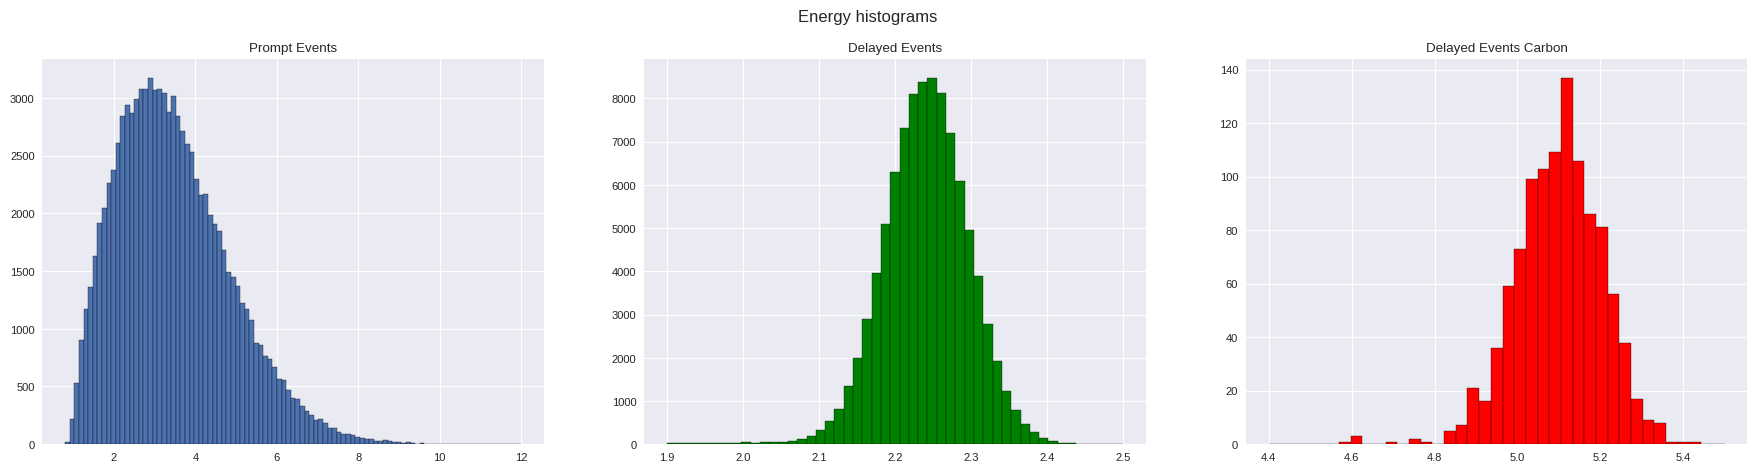

In [65]:
fig_dp, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,5))
fig_dp.suptitle("Energy histograms")

ax1.hist(prompt_events["m_QEn"], np.linspace(0.8,12,100))
ax1.set_title("Prompt Events")
ax2.hist(delay_events["m_QEn"], np.linspace(1.9,2.5,50), color = 'green')
ax2.set_title("Delayed Events")
ax3.hist(delay_events_carb["m_QEn"], np.linspace(4.4,5.5,40), color = 'red')
ax3.set_title("Delayed Events Carbon")

In [66]:
from scipy.stats import norm
(mu, sigma) = norm.fit(delay_events["m_QEn"])
(mu_carb, sigma_carb) = norm.fit(delay_events_carb["m_QEn"])

print(mu, sigma)
print(mu_carb, sigma_carb)


2.2407973 0.05627225
5.1002684 0.10461817


# **Efficency**

In [67]:
(len(prompt_events)+len(delay_events)+len(delay_events_carb))/len(dataset)

3800.54

In [68]:
print("% of delay events at ~4.9MeV",len(delay_events_carb)/(len(delay_events)+len(delay_events_carb)) * 100)


print("% of delay events at ~2.2MeV",len(delay_events)/(len(delay_events)+len(delay_events_carb)) * 100)

% of delay events at ~4.9MeV 1.12713496316142
% of delay events at ~2.2MeV 98.87286503683858


# **Efficency cuts distibution**


Delta time variations

In [69]:
delta_time_series = [0.2e6, 0.3e6, 0.4e6, 0.5e6, 0.6e6, 0.7e6, 0.8e6, 1e6]


for t in range(len(delta_time_series)):
    prompt_columns = []
    delay_columns = []
    delay_columns_carb = []
    for i in range(len(dataset)-1):
        if dataset["m_triggerT"][i+1] - dataset["m_triggerT"][i] < delta_time_series[t]: #time cut
            if dist(dataset['recx'][i+1],dataset['recx'][i],dataset['recy'][i+1],dataset['recy'][i],dataset['recz'][i+1],dataset['recz'][i]) < delta_radius: #radius cut
                if dataset["m_QEn"][i]>= min_energy_prompt and dataset["m_QEn"][i]<= max_energy_prompt:
                    if dataset["m_QEn"][i+1]>= min_energy_delay and dataset["m_QEn"][i+1]<= max_energy_delay:
                        prompt_columns.append(i)
                        delay_columns.append(i+1)
                    if dataset["m_QEn"][i+1]>= min_energy_delay_carb and dataset["m_QEn"][i+1]<= max_energy_delay_carb:
                        delay_columns_carb.append(i+1)
    prompt_events = dataset.iloc[prompt_columns]
    delay_events = dataset.iloc[delay_columns]
    delay_events_carb = dataset.iloc[delay_columns_carb]
    print(delta_time_series[t], " -> ",(len(prompt_events)+len(delay_events)+len(delay_events_carb))/len(dataset))




AttributeError: 'dict' object has no attribute 'iloc'

Delta Radius Variations

In [ ]:
delta_radius_series = [800, 1000, 1100, 1200, 1300, 1400, 1500, 1600]


for t in range(len(delta_time_series)):
    prompt_columns = []
    delay_columns = []
    delay_columns_carb = []
    for i in range(len(dataset)-1):
        if dataset["m_triggerT"][i+1] - dataset["m_triggerT"][i] < delta_time: #time cut
            if dist(dataset['recx'][i+1],dataset['recx'][i],dataset['recy'][i+1],dataset['recy'][i],dataset['recz'][i+1],dataset['recz'][i]) < delta_radius_series[t]: #radius cut
                if dataset["m_QEn"][i]>= min_energy_prompt and dataset["m_QEn"][i]<= max_energy_prompt:
                    if dataset["m_QEn"][i+1]>= min_energy_delay and dataset["m_QEn"][i+1]<= max_energy_delay:
                        prompt_columns.append(i)
                        delay_columns.append(i+1)
                    if dataset["m_QEn"][i+1]>= min_energy_delay_carb and dataset["m_QEn"][i+1]<= max_energy_delay_carb:
                        delay_columns_carb.append(i+1)
    prompt_events = dataset.iloc[prompt_columns]
    delay_events = dataset.iloc[delay_columns]
    delay_events_carb = dataset.iloc[delay_columns_carb]
    print(delta_radius_series[t], " -> ",(len(prompt_events)+len(delay_events)+len(delay_events_carb))/len(dataset))


# Questions: 
-  I did the selection assuming that the delayed event alway comes after the prompt, but assuming that there are 2 different IBD events spatially close, if the second prompt event appens befor the first delayed one, we lose an event or am I wrong?
-  The delta_time histogram 